### Introduction
This project takes hydrodynamics data of various yachts based on a 43' sloop by Standmast and uses a neural network to predict hull performance. The data was obtained from the UCI machine learning repository at the following location:
https://archive.ics.uci.edu/dataset/243/yacht+hydrodynamics.  
This dataset was created by the Delft Ship Hydrodynamics Laboratory for the purpose of predicting the residuary hull resistance, which is used for estimating the required propulsive power of the vessel. The data consists of 308 full scale experiments of 22 different hull forms.  

The model is a neural network built using Pytorch consisting of two linear layers, a ReLU activation function, and 20 hidden neurons and achieves a mean squared error of 1.580 on the testing data.

___
### Prepping the data

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split

In [2]:
# load and display the data
df = pd.read_csv('yacht_hydrodynamics.data', delim_whitespace=True)
df

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


According to the dataset creators, the provided columns are:
1. Center of Bouyancy (longitudinal position)
2. Prismatic coefficient
3. Length-displacement ratio
4. Beam-draught ratio
5. Length-beam ratio
6. Froude number
7. Residuary resistance - measured variable

These values are adimensional. The goal of this project is to use the parameters in the first 6 columns to predict values for residuary hull resistance.  

First, we'll tidy up the data a bit.

In [3]:
# add column names
df.rename(columns={ df.columns[0]: 'cob', df.columns[1]: 'prism_coef', df.columns[2]: 'ld_ratio', df.columns[3]: 'bd_ratio',\
                   df.columns[4]: 'lb_ratio', df.columns[5]: 'froude', df.columns[6]: 'rr'}, inplace=True)
df

,cob,prism_coef,ld_ratio,bd_ratio,lb_ratio,froude,rr
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


Lastly, we'll check for any missing values in the data.

In [4]:
# check for missing entries
df.isna().sum()

cob           0
prism_coef    0
ld_ratio      0
bd_ratio      0
lb_ratio      0
froude        0
rr            0
dtype: int64

There are no null entries, so the dataset is prepped and ready to be used.

___
### Making the Neural Network

In [5]:
# create torch tensors 
X = torch.from_numpy(df.iloc[:, [0,1,2,3,4,5]].values).float()
Y = torch.from_numpy(df['rr'].values).float()

In [6]:
# split the data into random train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2)

In [7]:
# match the number of rows in X and y
y_train = y_train.unsqueeze(1)
print(f'X: {X_train.shape} Y: {y_train.shape}')

X: torch.Size([245, 6]) Y: torch.Size([245, 1])


In [8]:
# define number of samples and features
n_samples, n_features = X_train.shape

In [9]:
# define input and output size of the network
input_size = n_features
output_size = 1
hidden_size = 20

In [10]:
# create the neural network
class NonLinearModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NonLinearModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) # first part of first linear layer
        self.relu = nn.ReLU() # second part of first layer - activation function

        self.layer2 = nn.Linear(hidden_size, output_size) # second linear layer
        
    # forward pass
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        yhat = self.layer2(x)

        return yhat
    
        

In [11]:
# create model object from class
model = NonLinearModel(input_size, hidden_size, output_size)

In [12]:
# define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [13]:
# training loop
epochs = 1000
total_loss = []

for epoch in range(epochs):
    Yhat = model(X_train)
    loss_batch = criterion(Yhat, y_train)
    total_loss.append(loss_batch.item())

    for x, y in zip(X_train, y_train):

        yhat = model(x)

        loss = criterion(yhat, y)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()


    Yhat = model(X_train) 

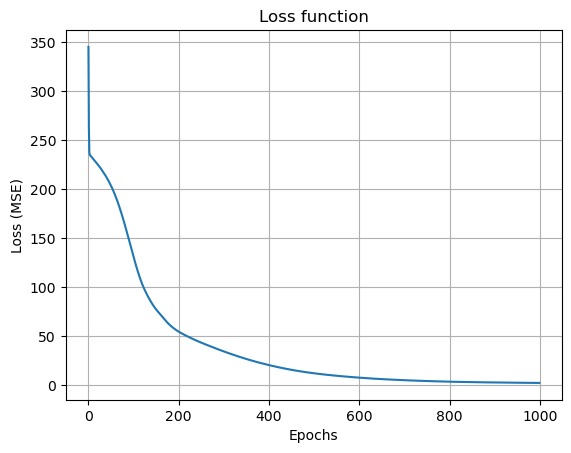

In [14]:
# plot the loss function
x_line = range(epochs)
plt.plot(x_line, total_loss)
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.title('Loss function')
plt.grid()
plt.show()

In [15]:
# use model to make predictions on the test set
predicted = model(X_test).detach().numpy() 
predicted = predicted.squeeze(1)

___
### Evaluation

Now that the model has been trained and predictions have been made using the test data, we can evaluate its accuracy using the mean squared error (MSE) metric.

In [16]:
# calculate error on test predictions
error = []
for x, y in zip(predicted, y_test):
    error.append((x - y)**2)

error = sum(error)/len(y_test)

print(f'The mean squared error on the test data is: {error:.3f}')

The mean squared error on the test data is: 1.580


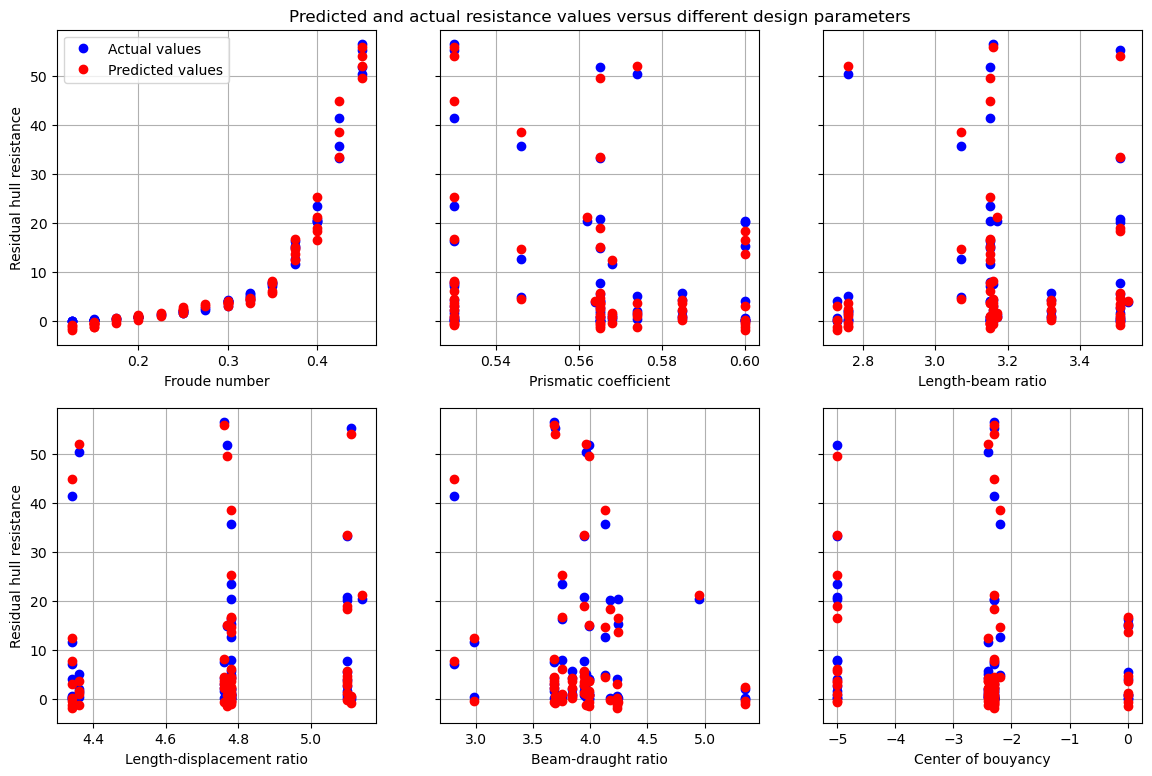

In [17]:
# plot predicted values and true values
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(14,9))
axs[0,0].plot(X_test[:,5], y_test, 'bo', label = 'Actual values')
axs[0,0].plot(X_test[:,5], predicted, 'ro', label = 'Predicted values')
axs[0,0].set_ylabel('Residual hull resistance')
axs[0,0].set_xlabel('Froude number')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(X_test[:,1], y_test, 'bo', label = 'True values')
axs[0,1].plot(X_test[:,1], predicted, 'ro', label = 'Predicted values')
axs[0,1].set_xlabel('Prismatic coefficient')
axs[0,1].set_title('Predicted and actual resistance values versus different design parameters')
axs[0,1].grid()

axs[0,2].plot(X_test[:,4], y_test, 'bo', label = 'True values')
axs[0,2].plot(X_test[:,4], predicted, 'ro', label = 'Predicted values')
axs[0,2].set_xlabel('Length-beam ratio')
axs[0,2].grid()


axs[1,0].plot(X_test[:,2], y_test, 'bo', label = 'True values')
axs[1,0].plot(X_test[:,2], predicted, 'ro', label = 'Predicted values')
axs[1,0].set_ylabel('Residual hull resistance')
axs[1,0].set_xlabel('Length-displacement ratio')
axs[1,0].grid()

axs[1,1].plot(X_test[:,3], y_test, 'bo', label = 'True values')
axs[1,1].plot(X_test[:,3], predicted, 'ro', label = 'Predicted values')
axs[1,1].set_xlabel('Beam-draught ratio')
axs[1,1].grid()

axs[1,2].plot(X_test[:,0], y_test, 'bo', label = 'True values')
axs[1,2].plot(X_test[:,0], predicted, 'ro', label = 'Predicted values')
axs[1,2].set_xlabel('Center of bouyancy')
axs[1,2].grid()

We can see from these diagrams that the predicted values are very close to the true values. The biggest factor influencing the accuracy of the predictions seems to be the froude number, for high values of the froude number the accuracy decreases. Nevertheless, the mean squared error of the predictions is 1.580 which is still a small margin and the model is a success.

Now that we have a working model, it can be saved and used to make predictions for new future combinations of the design parameters and we can expect a reasonable degree of accuracy.

In [18]:
# input new design parameters
cob = -5
prism_coef = 0.55
ld_ratio = 2
bd_ratio = 2
lb_ratio = 4.2
froude= 0.5

In [19]:
# predict hull resistance
test = torch.tensor([cob, prism_coef, ld_ratio,	bd_ratio, lb_ratio, froude]) 
test_prediction = model(test).detach().numpy()
print(test_prediction)

[98.23367]


In [20]:
# # save the model
# PATH = './yacht_hydro_model.pth'
# torch.save(model.state_dict(), PATH)